# Lab 1 - Differential Expression analysis
## Differential expression analysis, an intuition

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, FloatSlider



In [2]:
def generate_data(distance,dispersion, n_points):
    dispersion = [[dispersion,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([0,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def generate_h0(distance,dispersion, n_points):
    dispersion = [[dispersion + (distance/2)**2,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def plot_random(data,data_s):
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)

def dist_plot(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random(data,data_s)
    plt.show()

In [ ]:
interact(dist_plot, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=100, continuous_update=False))

### Questions

## The t-test

In [3]:
def plot_random_ttest(data,data_s):
    plt.rcParams["figure.figsize"] = (20,10)
    cond1 = data[data['Condition'] == 1]
    cond2 = data[data['Condition'] == 2]
    cond1_s = data_s[data_s['Condition'] == 1]
    cond2_s = data_s[data_s['Condition'] == 2]
    ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
    ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    ax[r1[0]].set_title('p = ' + str(np.round(ttestp, 5)))
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)
    ax[r1[1]].set_title('p = ' + str(np.round(ttestp_s,5)))
    

def dist_plot_ttest(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random_ttest(data,data_s)
    plt.show()

In [ ]:
interact(dist_plot_ttest, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=100, continuous_update=False))

Questions: 
* What assumptions about the data doest the t-test make?
* Are they compatible with gene expression data? If not, how to go around it? 

## Volcano plot

## Exercise, differential gene expression analysis

## Calculating FDR

In [109]:
def generate_data_with_condition(distance,dispersion, n_points):
    dispersion = [[dispersion,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([0,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    data_s = shuffle_condition(data)
    cond1_s = data_s[data_s['Condition'] == 1]
    cond2_s = data_s[data_s['Condition'] == 2]
    return data, data_s, cond1, cond2, cond1_s, cond2_s

def multiple_tests(distance,dispersion, n_points, n_tests):
    h0_stats = []
    h1_stats = []
    for i in range(n_tests):
        data = generate_data(distance,dispersion, n_points)
        data_h0 = generate_h0(distance,dispersion, n_points)
        cond1 = data[data['Condition'] == 1]
        cond2 = data[data['Condition'] == 2]
        cond1_s = data_h0[data_h0['Condition'] == 1]
        cond2_s = data_h0[data_h0['Condition'] == 2]
        ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
        ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
        h0_stats.append(ttestp_s)
        h1_stats.append(ttestp)
    return h0_stats, h1_stats

def plot_hist(h0_stats, h1_stats, bins):
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    ax[r1[0]].hist(h0_stats, bins = bins)
    ax[r1[1]].hist(h1_stats, bins = bins)
    
def plot_hist_comb(h0_stats, h1_stats, bins, threshold):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    ax[1].hist([h0_stats, h1_stats], bins = bins, stacked = True)
    ax[1].vlines(threshold, 0, max(np.histogram([h0,h1], bins=bins)[0]), color='r', linestyles = 'dashed')
    stats = pd.DataFrame(h1 + h0, columns = ['p'])
    stats['h'] = np.repeat(1,len(h1)).tolist() + np.repeat(0,len(h0)).tolist()
    stats['good'] = (stats['p'] <= threshold)*1
    stats = stats.sort_values('p')
    stack1 = stats['h']
    stack2 = stats['good']
    side = np.ceil(np.sqrt(len(stack1))).astype(int)
    pad1 = np.zeros(side*side)+9
    pad2 = np.zeros(side*side)+9
    pad1[:len(stack1)]=stack1
    pad2[:len(stack1)]=stack2 * 5
    ax[0].imshow(pad1.reshape(side,side), cmap = 'Set1')
    ax[0].imshow(pad2.reshape(side,side), cmap = 'Set1', alpha = 0.4)
    



In [9]:


h0,h1 = multiple_tests(2, 10, 20, 1000)


In [46]:
max(np.histogram([h0,h1], bins = 20)[0])

532

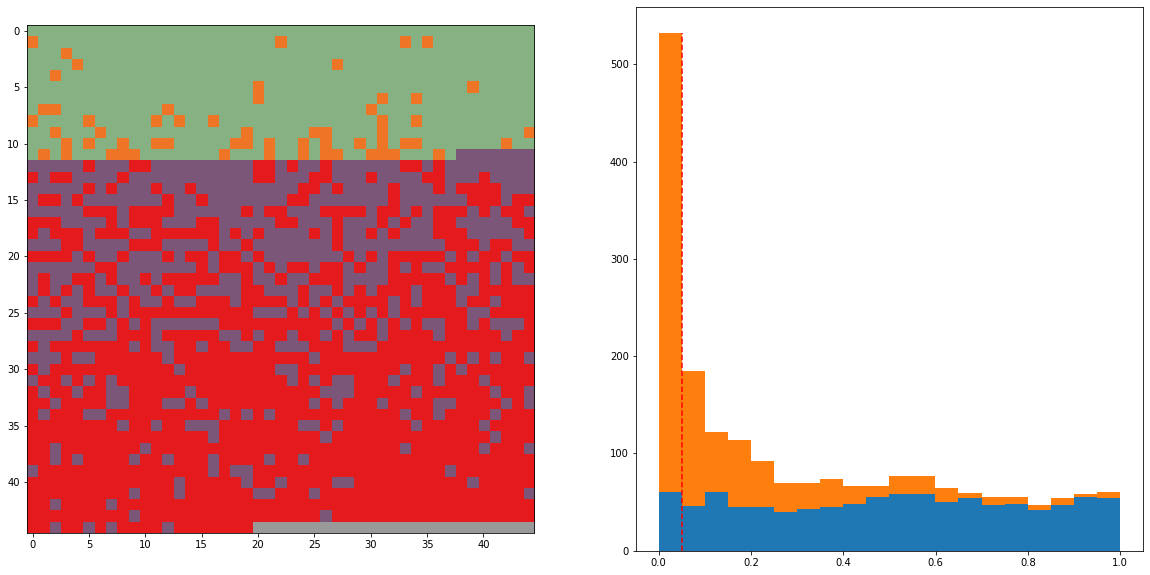

In [110]:
plot_hist_comb(h0, h1, 20, 0.05)

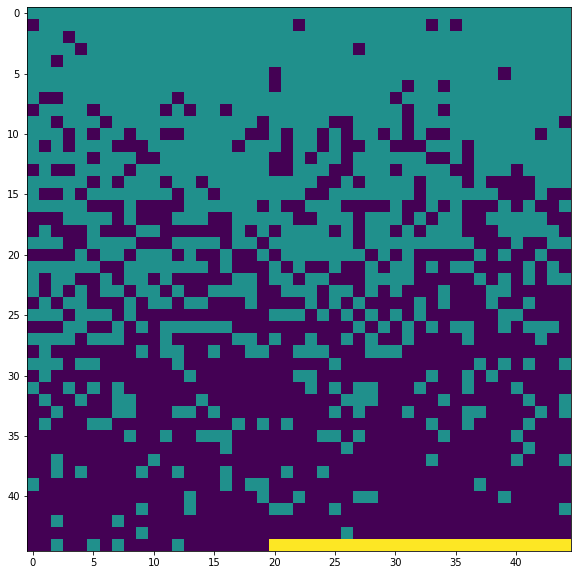

In [74]:
stats = pd.DataFrame(h1 + h0)
stats['h'] = np.repeat(1,len(h1)).tolist() + np.repeat(0,len(h0)).tolist()
stack = stats.sort_values(0)['h']
side = np.ceil(np.sqrt(len(stack))).astype(int)
pad = np.zeros(side*side)+2
pad[:len(stack)]=stack

plt.imshow(pad.reshape(side,side))